# LDA Subspace

In [1]:
import numpy as np
import torch

import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

def plot_2D_scatter(X_trans, y):
    fig, (ax) = plt.subplots(1, figsize=(5, 5), gridspec_kw={'hspace': 0.40})
    ax.scatter(X_trans[:, 0], X_trans[:, 1], c=y)
    plt.show()

## Numpy

In [55]:
X_1 = np.random.normal(1, 0.4, (5,20))
y_1 = np.zeros(5)
X_2 = np.random.normal(1, 1.2, (5,20))
y_2 = np.ones(5)

X = np.concatenate((X_1, X_2)).astype('float32')
y = np.concatenate((y_1, y_2)).astype('float32')

[[ 1.00818609e+07  2.16097593e+07 -1.52633094e+07 -2.05937109e+07
  -3.26516515e+07  4.74309609e+07  1.05345549e+07  1.22197511e+07
  -2.96661137e+07  4.09626588e+06  2.73933710e+07  3.39963209e+06
   2.15435678e+06  1.68071463e+07  2.85656623e+07 -1.64518561e+07
   7.76855723e+06  2.05664719e+07  2.37730608e+07 -2.17950580e+07]
 [-3.16260259e+06 -6.77881585e+06  4.78798313e+06  6.46008941e+06
   1.02425729e+07 -1.48787290e+07 -3.30460906e+06 -3.83324221e+06
   9.30603239e+06 -1.28496722e+06 -8.59309031e+06 -1.06643851e+06
  -6.75805210e+05 -5.27227300e+06 -8.96082946e+06  5.16082111e+06
  -2.43693685e+06 -6.45154439e+06 -7.45742679e+06  6.83694254e+06]
 [ 3.47098726e+06  7.43981699e+06 -5.25485872e+06 -7.09001115e+06
  -1.12413244e+07  1.63295508e+07  3.62684118e+06  4.20702098e+06
  -1.02134622e+07  1.41026415e+06  9.43100133e+06  1.17042680e+06
   7.41702879e+05  5.78637158e+06  9.83459834e+06 -5.66405206e+06
   2.67456210e+06  7.08063374e+06  8.18459945e+06 -7.50361176e+06]
 [-8.09

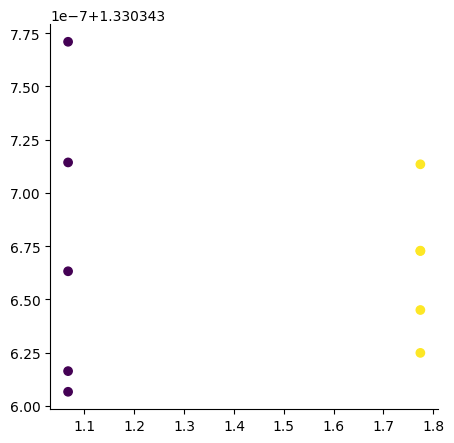

0j

In [56]:
class LDA:

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]

            mean_c = np.mean(X_c, axis=0)
            # (4, n_c) * (n_c, 4) = (4,4) -> transpose
            SW += (X_c - mean_c).T.dot((X_c - mean_c))

            # (4, 1) * (1, 4) = (4,4) -> reshape
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        # Determine SW^-1 * SB
        A = np.linalg.inv(SW).dot(SB)
        print(A)
        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(A)


        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T
        
        idxs = np.argsort(abs(eigenvalues))[::-1]
        self.eigenvals = eigenvalues[idxs]
        self.eigenvecs = eigenvectors[idxs]
        self.inverse_eigenvecs = np.linalg.inv(self.eigenvecs)

    
lda = LDA()
lda.fit(X,y)
X_trans = np.dot(X, lda.eigenvecs.T)

plot_2D_scatter(X_trans, y)

X_recovered = np.dot(X_trans, lda.inverse_eigenvecs.T)
np.round(X_recovered - X, 6).sum()

## Torch

In [78]:
#X_1 = torch.normal(1, 0.4, size=(5,20))
#y_1 = torch.zeros(5)
#X_2 = torch.normal(1, 1.2, size=(5,20))
#y_2 = torch.ones(5)

#X = torch.cat((X_1, X_2))
#y = torch.cat((y_1, y_2))

X = torch.FloatTensor(X).type(torch.float32)
y = torch.FloatTensor(y).type(torch.float32)

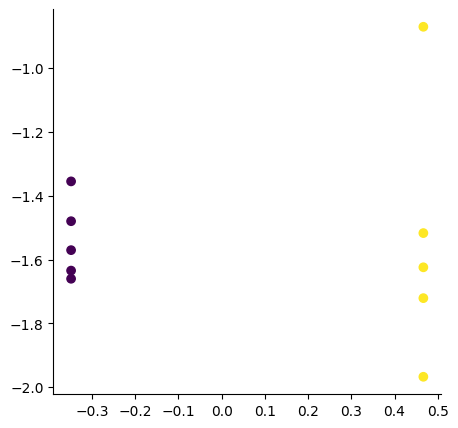

In [79]:
class LDA:

    def fit(self, X, y):
        
        n_features = X.shape[1]
        class_labels = torch.unique(y)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        mean_overall = X.mean(0)
        SW = torch.zeros((n_features, n_features))
        SB = torch.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = X_c.mean(0)
            # (4, n_c) * (n_c, 4) = (4,4) -> transpose
            SW += (X_c - mean_c).T@((X_c - mean_c))

            # (4, 1) * (1, 4) = (4,4) -> reshape
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff) @ (mean_diff.T)

        # Determine SW^-1 * SB
        A = torch.linalg.inv(SW)@(SB)
        #A = torch.linalg.tensorinv(SW, ind=1)@(SB)
        #A = torch.linalg.solve(SW, SB)

        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = torch.linalg.eig(A)
        
        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T

        idxs = torch.argsort(abs(eigenvalues), descending=True)
        self.eigenvals = eigenvalues[idxs]
        self.eigenvecs = eigenvectors[idxs]
        self.inverse_eigenvecs = np.linalg.inv(self.eigenvecs)
        
        #self.eigenvals = torch.view_as_real(eigenvals)[...,0]
        #self.eigenvecs = torch.view_as_real(eigenvecs)[...,0]
        #self.inverse_eigenvecs = torch.view_as_real(inverse_eigenvecs)[...,0]
        
lda = LDA()
lda.fit(X,y)
X_trans = X @ lda.eigenvecs.T.real

plot_2D_scatter(X_trans, y)

X_recovered = X_trans @ lda.inverse_eigenvecs.T.real

# Numpy / Torch Mixture

In [87]:
X_1 = torch.normal(1, 0.4, size=(5,20))
y_1 = torch.zeros(5)
X_2 = torch.normal(1, 1.2, size=(5,20))
y_2 = torch.ones(5)

X = torch.cat((X_1, X_2))
y = torch.cat((y_1, y_2))

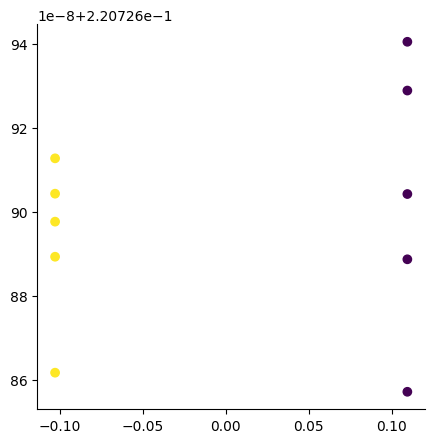

In [127]:
class LDA:

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]

            mean_c = np.mean(X_c, axis=0)
            # (4, n_c) * (n_c, 4) = (4,4) -> transpose
            SW += (X_c - mean_c).T.dot((X_c - mean_c))

            # (4, 1) * (1, 4) = (4,4) -> reshape
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        # Determine SW^-1 * SB
        A = np.linalg.inv(SW).dot(SB)
        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(A)


        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T
        
        idxs = np.argsort(abs(eigenvalues))[::-1]
        self.eigenvals = eigenvalues[idxs]
        self.eigenvecs = eigenvectors[idxs]
        self.inverse_eigenvecs = np.linalg.inv(eigenvectors[idxs])

    
lda = LDA()
lda.fit(X.numpy(),y.numpy())
X_trans = X@ lda.eigenvecs.T

plot_2D_scatter(X_trans, y)

X_recovered = X_trans@ lda.inverse_eigenvecs.T
